## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

## Data Processing

In [ ]:
# LG business segments
categories = ['Home Entertainment', 'Home Appliances', 'Mobile & Personal Devices', 
              'Business Solutions', 'Automotive & Mobility Technologies']

data = pd.read_csv("customer_segmentation_data.csv")

data.head()

# 1. CUSTOMER SEGMENTATION
# print("1. CUSTOMER SEGMENTATION")
# print("-" * 30)

,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,1,38,Female,99342,90,3,24,Home Entertainment,113.53
1,2,21,Female,78852,60,2,42,Home Appliances,41.93
2,3,60,Female,126573,30,2,28,Mobile & Personal Devices,424.36
3,4,40,Other,47099,74,9,5,Business Solutions,991.93
4,5,65,Female,140621,21,3,25,Automotive & Mobility Technologies,347.08


## Data Scaling

In [3]:
# Prepare features for clustering
features = ['spending_score', 'membership_years']
X = data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Determine Optimal Cluster using silhouetter Score
### Customer Segmentation

In [4]:
# Find optimal clusters using silhouette score
silhouette_scores = []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of segments: {optimal_k}")

Optimal number of segments: 4


## Clustering Model using the optimal number of segments

In [5]:
# Final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['segment'] = kmeans.fit_predict(X_scaled)

## Segment Analysis and Assignment of tier

In [6]:
# Segment analysis
segment_analysis = data.groupby('segment').agg({
    'spending_score': 'mean',
    'membership_years': 'mean',
    'age': 'mean',
    'income': 'mean',
    'purchase_frequency': 'mean',
    'last_purchase_amount': 'mean'
}).round(2)

# Assign tier-based segment names (Diamond, Gold, Silver, Bronze)
segment_scores = []
for i in range(optimal_k):
    seg_data = segment_analysis.loc[i]
    # Calculate composite score based on spending_score and membership_years
    composite_score = (seg_data['spending_score'] * 0.6) + (seg_data['membership_years'] * 10 * 0.4)
    segment_scores.append((i, composite_score))

# Sort by composite score and assign tier names
segment_scores.sort(key=lambda x: x[1], reverse=True)
tier_names = ["Diamond", "Gold", "Silver", "Bronze"]

segment_names = [None] * optimal_k
for rank, (segment_id, _) in enumerate(segment_scores):
    if rank < len(tier_names):
        segment_names[segment_id] = tier_names[rank]
    else:
        segment_names[segment_id] = f"Tier {rank + 1}"

segment_analysis['segment_name'] = segment_names
print("\nSegment Characteristics:")
display(segment_analysis)

# Category preferences by segment
category_by_segment = pd.crosstab(data['segment'], data['preferred_category'], normalize='index') * 100
print("\nCategory Preferences by Segment (%):")
display(category_by_segment.round(1))


Segment Characteristics:


,spending_score,membership_years,age,income,purchase_frequency,last_purchase_amount,segment_name
segment,,,,,,,
0,25.59,7.94,43.70,88293.24,26.08,467.17,Silver
1,75.69,3.01,44.48,88289.82,25.53,479.68,Gold
2,25.94,3.16,42.97,90906.68,26.13,516.31,Bronze
3,77.17,8.12,44.02,86267.57,28.77,504.79,Diamond



Category Preferences by Segment (%):


preferred_category,Automotive & Mobility Technologies,Business Solutions,Home Appliances,Home Entertainment,Mobile & Personal Devices
segment,,,,,
0,24.3,16.9,21.4,19.3,18.1
1,18.6,19.4,20.2,21.7,20.2
2,20.8,25.7,21.5,18.5,13.6
3,22.6,20.1,20.9,20.1,16.3


### Market Strategy Recommendations

In [7]:
# # 2. MARKETING STRATEGY RECOMMENDATION
print("\n2. MARKETING STRATEGIES BY SEGMENT")
print("-" * 40)

for i, name in enumerate(segment_names):
    seg_data = segment_analysis.loc[i]
    top_category = category_by_segment.loc[i].idxmax()
    print(f"\n{name} (Segment {i}):")
    print(f"  • Top Category: {top_category}")
    print(f"  • Avg Spending Score: {seg_data['spending_score']}")
    
    if seg_data['spending_score'] > 70:
        strategy = "Premium product focus, exclusive offers, VIP treatment"
    elif seg_data['purchase_frequency'] < 8:
        strategy = "Re-engagement campaigns, personalized discounts, product trials"
    elif seg_data['membership_years'] > 6:
        strategy = "Loyalty rewards, referral programs, early access to new products"
    else:
        strategy = "Value proposition focus, bundle deals, educational content"
    
    print(f"  • Strategy: {strategy}")


2. MARKETING STRATEGIES BY SEGMENT
----------------------------------------

Silver (Segment 0):
  • Top Category: Automotive & Mobility Technologies
  • Avg Spending Score: 25.59
  • Strategy: Loyalty rewards, referral programs, early access to new products

Gold (Segment 1):
  • Top Category: Home Entertainment
  • Avg Spending Score: 75.69
  • Strategy: Premium product focus, exclusive offers, VIP treatment

Bronze (Segment 2):
  • Top Category: Business Solutions
  • Avg Spending Score: 25.94
  • Strategy: Value proposition focus, bundle deals, educational content

Diamond (Segment 3):
  • Top Category: Automotive & Mobility Technologies
  • Avg Spending Score: 77.17
  • Strategy: Premium product focus, exclusive offers, VIP treatment


### Demand Forecasting

In [8]:
# 3. DEMAND FORECASTING
print("\n3. DEMAND FORECASTING BY CATEGORY")
print("-" * 35)

# Create demand proxy using purchase frequency and spending
data['demand_proxy'] = data['purchase_frequency'] * (data['spending_score'] / 100) * (data['last_purchase_amount'] / 1000)

# Forecast demand by category and segment
forecast_features = ['age', 'income', 'spending_score', 'membership_years']
demand_forecasts = {}

for category in categories:
    cat_data = data[data['preferred_category'] == category]
    if len(cat_data) > 20:  # Minimum samples for reliable forecast
        X_cat = cat_data[forecast_features]
        y_cat = cat_data['demand_proxy']
        
        rf = RandomForestRegressor(n_estimators=50, random_state=42)
        rf.fit(X_cat, y_cat)
        
        # Predict demand for next period
        future_demand = rf.predict(X_cat).mean()
        demand_forecasts[category] = {
            'current_avg_demand': y_cat.mean(),
            'forecast_demand': future_demand,
            'growth_rate': ((future_demand - y_cat.mean()) / y_cat.mean()) * 100
        }

for cat, forecast in demand_forecasts.items():
    print(f"\n{cat}:")
    print(f"  • Current Demand: {forecast['current_avg_demand']:.2f}")
    print(f"  • Forecasted Demand: {forecast['forecast_demand']:.2f}")
    print(f"  • Growth Rate: {forecast['growth_rate']:.1f}%")



3. DEMAND FORECASTING BY CATEGORY
-----------------------------------

Home Entertainment:
  • Current Demand: 7.34
  • Forecasted Demand: 7.46
  • Growth Rate: 1.7%

Home Appliances:
  • Current Demand: 6.83
  • Forecasted Demand: 6.87
  • Growth Rate: 0.6%

Mobile & Personal Devices:
  • Current Demand: 6.15
  • Forecasted Demand: 6.37
  • Growth Rate: 3.7%

Business Solutions:
  • Current Demand: 6.69
  • Forecasted Demand: 6.81
  • Growth Rate: 1.9%

Automotive & Mobility Technologies:
  • Current Demand: 6.38
  • Forecasted Demand: 6.47
  • Growth Rate: 1.5%


### Price Optimization

In [9]:
# 4. PRICE OPTIMIZATION
print("\n4. PRICE OPTIMIZATION BY SEGMENT")
print("-" * 35)

# Price elasticity simulation
def demand_function(price, base_demand, elasticity):
    """Simulate demand based on price elasticity"""
    return base_demand * (price ** elasticity)

def revenue_function(price, base_demand, elasticity):
    """Calculate revenue = price * demand"""
    return price * demand_function(price, base_demand, elasticity)

price_recommendations = {}

for i, name in enumerate(segment_names):
    seg_customers = data[data['segment'] == i]
    avg_purchase = seg_customers['last_purchase_amount'].mean()
    avg_score = seg_customers['spending_score'].mean()
    
    # Estimate price elasticity based on spending behavior
    if avg_score > 70:
        elasticity = -0.5  # Less price sensitive
    elif avg_score < 40:
        elasticity = -1.5  # More price sensitive
    else:
        elasticity = -1.0  # Moderate sensitivity
    
    base_demand = seg_customers['purchase_frequency'].mean()
    current_price = avg_purchase
    
    # Optimize price for maximum revenue
    result = minimize_scalar(
        lambda p: -revenue_function(p, base_demand, elasticity),
        bounds=(current_price * 0.7, current_price * 1.3),
        method='bounded'
    )
    
    optimal_price = result.x
    price_change = ((optimal_price - current_price) / current_price) * 100
    
    price_recommendations[name] = {
        'current_price': current_price,
        'optimal_price': optimal_price,
        'price_change': price_change,
        'elasticity': elasticity
    }
    
    print(f"\n{name}:")
    print(f"  • Current Avg Price: ${current_price:.0f}")
    print(f"  • Optimal Price: ${optimal_price:.0f}")
    print(f"  • Recommended Change: {price_change:+.1f}%")
    print(f"  • Price Elasticity: {elasticity}")


4. PRICE OPTIMIZATION BY SEGMENT
-----------------------------------

Silver:
  • Current Avg Price: $467
  • Optimal Price: $327
  • Recommended Change: -30.0%
  • Price Elasticity: -1.5

Gold:
  • Current Avg Price: $480
  • Optimal Price: $624
  • Recommended Change: +30.0%
  • Price Elasticity: -0.5

Bronze:
  • Current Avg Price: $516
  • Optimal Price: $361
  • Recommended Change: -30.0%
  • Price Elasticity: -1.5

Diamond:
  • Current Avg Price: $505
  • Optimal Price: $656
  • Recommended Change: +30.0%
  • Price Elasticity: -0.5


### Visualization


5. GENERATING VISUALIZATIONS...


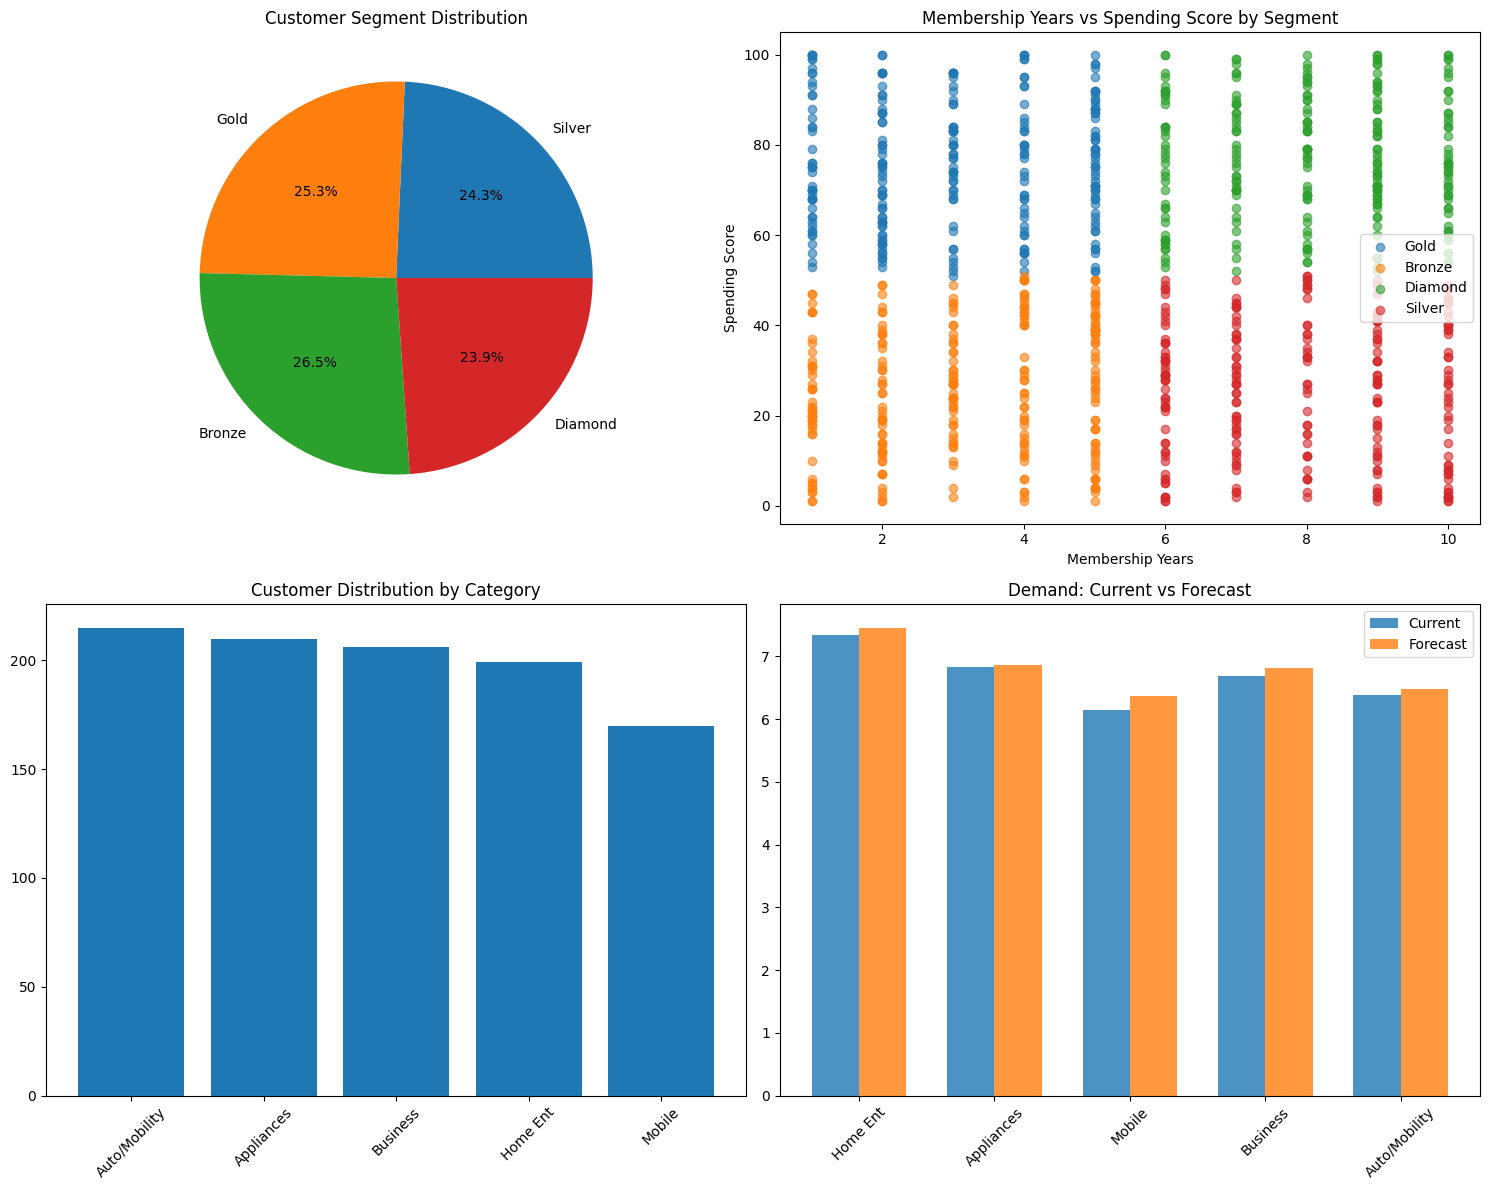

In [10]:
# 5. VISUALIZATION
print("\n5. GENERATING VISUALIZATIONS...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Segment distribution
segment_counts = data['segment'].value_counts().sort_index()
segment_labels = [segment_names[i] for i in segment_counts.index]
axes[0,0].pie(segment_counts.values, labels=segment_labels, autopct='%1.1f%%')
axes[0,0].set_title('Customer Segment Distribution')

# Spending vs Membership by segment
for seg in data['segment'].unique():
    seg_data = data[data['segment'] == seg]
    axes[0,1].scatter(seg_data['membership_years'], seg_data['spending_score'], 
                     label=segment_names[seg], alpha=0.6)
axes[0,1].set_xlabel('Membership Years')
axes[0,1].set_ylabel('Spending Score')
axes[0,1].set_title('Membership Years vs Spending Score by Segment')
axes[0,1].legend()

# Category preferences
category_counts = data['preferred_category'].value_counts()
# Create abbreviated category names
category_abbrev = {
    'Home Entertainment': 'Home Ent',
    'Home Appliances': 'Appliances', 
    'Mobile & Personal Devices': 'Mobile',
    'Business Solutions': 'Business',
    'Automotive & Mobility Technologies': 'Auto/Mobility'
}
abbreviated_names = [category_abbrev.get(cat, cat) for cat in category_counts.index]

axes[1,0].bar(range(len(category_counts)), category_counts.values)
axes[1,0].set_xticks(range(len(category_counts)))
axes[1,0].set_xticklabels(abbreviated_names, rotation=45)
axes[1,0].set_title('Customer Distribution by Category')

# Demand forecast
if demand_forecasts:
    # Use the same abbreviation mapping for consistency
    categories_short = [category_abbrev.get(cat, cat) for cat in demand_forecasts.keys()]
    current_demands = [forecast['current_avg_demand'] for forecast in demand_forecasts.values()]
    forecast_demands = [forecast['forecast_demand'] for forecast in demand_forecasts.values()]
    
    x = np.arange(len(categories_short))
    width = 0.35
    
    axes[1,1].bar(x - width/2, current_demands, width, label='Current', alpha=0.8)
    axes[1,1].bar(x + width/2, forecast_demands, width, label='Forecast', alpha=0.8)
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(categories_short, rotation=45)
    axes[1,1].set_title('Demand: Current vs Forecast')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

In [11]:
# 6. SUMMARY INSIGHTs
summary_md = f"""
## 6. Key Insights & Recommendations

- Identified **{optimal_k}** distinct customer segments
- **{categories[0]}** shows highest customer preference
- Premium customers require exclusive, high-value offerings
- Low engagement segments need re-activation campaigns
- Price optimization suggests differentiated pricing strategy
- Focus on high-growth categories for expansion

**Analysis Complete! 📊**
"""

# Display in Markdown
from IPython.display import Markdown
display(Markdown(summary_md))


## 6. Key Insights & Recommendations

- Identified **4** distinct customer segments
- **Home Entertainment** shows highest customer preference
- Premium customers require exclusive, high-value offerings
- Low engagement segments need re-activation campaigns
- Price optimization suggests differentiated pricing strategy
- Focus on high-growth categories for expansion

**Analysis Complete! 📊**


## Model Deployment 

In [13]:
import pickle

# Create a deployment dictionary
deployment_package = {
    'scaler': scaler,
    'kmeans_model': kmeans,
    'segment_names': segment_names,
    'segment_analysis': segment_analysis,
    'category_by_segment': category_by_segment,
    'category_abbrev': category_abbrev,
    'price_recommendations': price_recommendations
}

# Store category-level demand forecasting models
for category in categories:
    cat_data = data[data['preferred_category'] == category]
    if len(cat_data) > 20:
        X_cat = cat_data[forecast_features]
        y_cat = cat_data['demand_proxy']

# Save to a Pickle file
with open('lg_cs_model.pkl', 'wb') as file:
    pickle.dump(deployment_package, file)

print("Model successfully saved")

Model successfully saved
